In [1]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D
import seaborn as sns
import matplotlib.pyplot as plt

2024-06-25 19:59:45.569045: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
notchloe = False

In [ ]:
def not_chloe(b):
    if b is True:
        return "elaineran", "Desktop"
    else: 
        return "chloezhao", "summer 2024 project"

In [ ]:
data_path = "/Users/"+not_chloe(notchloe)[0] + "/"+not_chloe(notchloe)[1]+"/summer-project/piano_notes/"
metadata_path = "/Users/"+not_chloe(notchloe)[0] +"/"+not_chloe(notchloe)[1]+"/summer-project/piano_notes.csv"

In [ ]:
def load_data(data_path, metadata_path):
    features = []
    labels = []


    metadata = pd.read_csv(metadata_path)


    for index, row in metadata.iterrows():
        file_path = os.path.join(data_path, f"{row['Chord']}.wav")


        # Load the audio file and resample it
        target_sr = 22050
        audio, sample_rate = librosa.load(file_path, sr=target_sr)

        # Check if the audio length is less than the default n_fft size
        if len(audio) < 2048:
            # Pad the audio file with zeros
            audio = np.pad(audio, (0, 2048 - len(audio)), mode='constant')



        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=audio, sr=target_sr, n_mfcc=40)
        mfccs_scaled = np.mean(mfccs.T, axis=0)


        # Append features and labels
        features.append(mfccs_scaled)
        labels.append(row['Chord_modified'])


    return np.array(features), np.array(labels)



In [ ]:
features, labels = load_data(data_path, metadata_path)


# Encode labels
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_onehot = to_categorical(labels_encoded)


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels_onehot, test_size=0.2, random_state=42)


In [ ]:
input_shape = (X_train.shape[1], 1)
model = Sequential()
model.add(Conv1D(64, 3, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Conv1D(128, 3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(le.classes_), activation='softmax'))


/Users/chloezhao/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.0689 - loss: 14.6012 - val_accuracy: 0.1031 - val_loss: 2.4559
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.1209 - loss: 3.4504 - val_accuracy: 0.1392 - val_loss: 2.3815
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.1487 - loss: 2.5222 - val_accuracy: 0.3144 - val_loss: 2.2199
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.2335 - loss: 2.2387 - val_accuracy: 0.3351 - val_loss: 1.9720
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.2860 - loss: 2.0754 - val_accuracy: 0.4897 - val_loss: 1.7043
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3817 - loss: 1.7871 - val_accuracy: 0.5412 - val_loss: 1.4598
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4208 - loss: 1.6873 - val_accuracy: 0.6134 - val_loss: 1.2879
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5193 - loss: 1.4566 - val_accuracy: 0

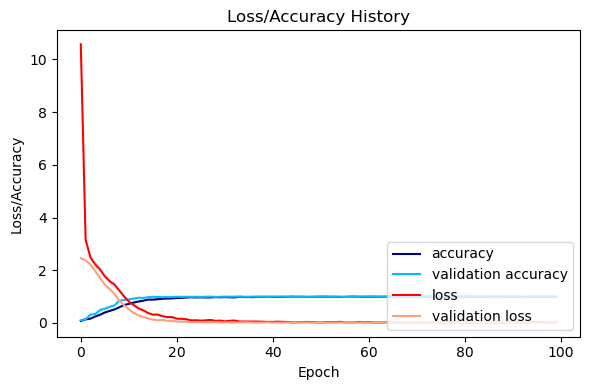

In [ ]:
# plotting from history

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = list(range(len(loss)))

figsize = (6, 4)
fig, axis1 = plt.subplots(figsize=figsize)
plot1_lacc = axis1.plot(epochs, acc, 'navy', label='accuracy')
plot1_val_lacc = axis1.plot(epochs, val_acc, 'deepskyblue', label="validation accuracy")

plot1_loss = axis1.plot(epochs, loss, 'red', label='loss')
plot1_val_loss = axis1.plot(epochs, val_loss, 'lightsalmon', label="validation loss")


plots = plot1_loss + plot1_val_loss
labs = [plot.get_label() for plot in plots]
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("Loss/Accuracy History")
plt.tight_layout()
axis1.legend(loc='lower right')
plt.savefig("/Users/chloezhao/summer 2024 project/summer-project/figures/Loss-Accuracy-Notes")
plt.show()

In [ ]:
test_predictions = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


In [ ]:
predicted_class_indices = np.argmax(test_predictions, axis=1)
predicted_classes = le.inverse_transform(predicted_class_indices)
print(predicted_classes)

['G#' 'G#' 'A' 'E' 'G' 'A' 'E' 'F#' 'A' 'F' 'C#' 'B' 'Bb' 'D' 'B' 'F' 'Eb'
 'E' 'Eb' 'A' 'C' 'G' 'B' 'E' 'Bb' 'G#' 'A' 'Eb' 'F#' 'D' 'Eb' 'F' 'C' 'E'
 'F' 'G' 'D' 'Bb' 'Eb' 'C#' 'B' 'A' 'C' 'Bb' 'G#' 'A' 'F#' 'Bb' 'G' 'A'
 'F' 'G' 'E' 'Eb' 'Eb' 'G#' 'B' 'A' 'Bb' 'C#' 'B' 'F#' 'A' 'Eb' 'G' 'Bb'
 'F#' 'E' 'C' 'Eb' 'F#' 'D' 'A' 'A' 'D' 'C' 'E' 'E' 'C' 'C' 'D' 'C#' 'G#'
 'F' 'A' 'G' 'C#' 'B' 'Bb' 'F#' 'G#' 'A' 'Eb' 'C' 'Eb' 'C#' 'B' 'F#' 'B'
 'G#' 'A' 'F#' 'F' 'G#' 'G#' 'Eb' 'G#' 'A' 'Bb' 'Eb' 'C' 'F' 'F' 'E' 'A'
 'D' 'C' 'G' 'B' 'G#' 'Bb' 'Eb' 'E' 'C' 'F' 'A' 'Eb' 'C#' 'B' 'C#' 'Eb'
 'D' 'B' 'F' 'Bb' 'F' 'E' 'G' 'G' 'A' 'G' 'A' 'G' 'C' 'C#' 'A' 'C' 'C#'
 'D' 'G' 'Bb' 'C#' 'B' 'G' 'E' 'G#' 'F' 'D' 'D' 'Bb' 'F#' 'Eb' 'Eb' 'F#'
 'C#' 'Eb' 'Eb' 'D' 'B' 'Bb' 'D' 'D' 'Eb' 'F' 'Eb' 'C' 'C' 'G#' 'C' 'F'
 'E' 'Bb' 'C' 'Bb' 'Bb' 'G#' 'F#' 'F#' 'Eb' 'G' 'C' 'F#' 'F#' 'E']


In [ ]:
y_true = np.argmax(y_test, axis=1)
true_classes = le.inverse_transform(y_true)
print(true_classes)

['G#' 'G#' 'A' 'E' 'G' 'A' 'E' 'F#' 'A' 'F' 'C#' 'B' 'Bb' 'D' 'B' 'F' 'Eb'
 'E' 'Eb' 'A' 'C' 'G' 'B' 'E' 'Bb' 'G#' 'A' 'Eb' 'F#' 'D' 'Eb' 'F' 'C' 'E'
 'F' 'G' 'D' 'Bb' 'Eb' 'C#' 'B' 'A' 'C' 'Bb' 'G#' 'A' 'F#' 'Bb' 'G' 'A'
 'F' 'G' 'E' 'Eb' 'Eb' 'G#' 'B' 'A' 'Bb' 'C#' 'B' 'F#' 'A' 'Eb' 'G' 'Bb'
 'F#' 'E' 'C' 'Eb' 'F#' 'D' 'A' 'A' 'D' 'C' 'E' 'E' 'C' 'C' 'D' 'C#' 'G#'
 'F' 'A' 'G' 'C#' 'B' 'Bb' 'F#' 'G#' 'A' 'Eb' 'C' 'Eb' 'C#' 'B' 'F#' 'B'
 'G#' 'A' 'F#' 'F' 'G#' 'G#' 'Eb' 'G#' 'A' 'Bb' 'Eb' 'C' 'F' 'F' 'E' 'A'
 'D' 'C' 'G' 'B' 'G#' 'Bb' 'Eb' 'E' 'C' 'F' 'A' 'Eb' 'C#' 'B' 'C#' 'Eb'
 'D' 'B' 'F' 'Bb' 'F' 'E' 'G' 'G' 'A' 'G' 'A' 'G' 'C' 'C#' 'A' 'C' 'C#'
 'D' 'G' 'Bb' 'C#' 'B' 'G' 'E' 'G#' 'F' 'D' 'D' 'Bb' 'F#' 'Eb' 'Eb' 'F#'
 'C#' 'Eb' 'Eb' 'D' 'B' 'Bb' 'D' 'D' 'Eb' 'F' 'Eb' 'C' 'C' 'G#' 'C' 'F'
 'D' 'Bb' 'C' 'Bb' 'Bb' 'G#' 'F#' 'F#' 'Eb' 'G' 'C' 'F#' 'F#' 'E']


In [ ]:
unique_labels = np.unique(np.concatenate([y_true, predicted_class_indices]))


# Calculate accuracy
accuracy = accuracy_score(y_true, predicted_class_indices)
print("Accuracy:", accuracy)


# Generate a classification report
print(classification_report(y_true, predicted_class_indices, labels=unique_labels, target_names=le.inverse_transform(unique_labels)))


# Confusion matrix
cm = confusion_matrix(y_true, predicted_class_indices)
print("Confusion Matrix:\n", cm)

Accuracy: 0.9948453608247423
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        21
           B       1.00      1.00      1.00        14
          Bb       1.00      1.00      1.00        17
           C       1.00      1.00      1.00        18
          C#       1.00      1.00      1.00        12
           D       1.00      0.93      0.97        15
           E       0.93      1.00      0.97        14
          Eb       1.00      1.00      1.00        23
           F       1.00      1.00      1.00        15
          F#       1.00      1.00      1.00        15
           G       1.00      1.00      1.00        15
          G#       1.00      1.00      1.00        15

    accuracy                           0.99       194
   macro avg       0.99      0.99      0.99       194
weighted avg       1.00      0.99      0.99       194

Confusion Matrix:
 [[21  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 14  0  0  0  0  0  0  0  0  0  0]
 [ 0  0

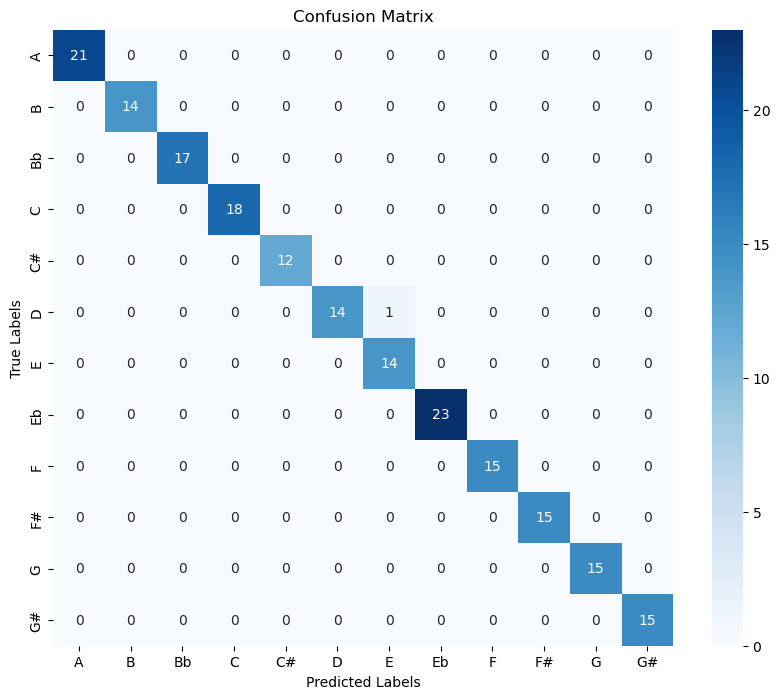

In [ ]:


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig("/Users/chloezhao/summer 2024 project/summer-project/figures/Confusion-Matrix-Notes")
plt.show()
